In [218]:
using Dates
using Plots

using Statistics

include("./Data Processing/data_processing.jl")

using .DataDownload
DD = DataDownload

include("./ESN/Reservoir.jl")
using .ESN

In [221]:
p2 = Dates.now()
p1 = Dates.now()-Year(1)
interval="1wk"
    
symbols = ["MSFT", "TSLA"]
stocks = DD.set_download(symbols, p1=p1, p2=p2, interval=interval)
stocks = DD.dictionary2array(stocks, symbols)

stocks = reshape(stocks, (size(stocks)[1], size(stocks)[2], 1, size(stocks)[3]))

(53, 6, 2)

53×6×1×2 Array{Float64, 4}:
[:, :, 1, 1] =
 294.31  303.13  287.17  289.86  1.57389e8       0.0
 288.53  289.69  270.0   280.07  1.84358e8  604800.0
 280.34  301.0   275.82  300.43  1.76939e8       1.2096e6
 298.89  305.5   294.9   303.68  1.28717e8       1.8144e6
 304.33  315.95  304.33  309.42  1.48668e8       2.4192e6
 310.09  315.11  296.28  296.97  1.4333e8        3.024e6
 291.79  292.61  279.32  279.83  1.15665e8       3.6288e6
 278.91  293.3   273.38  274.03  1.24843e8       4.2336e6
 273.29  290.98  270.0   277.52  2.16396e8       4.8384e6
 277.71  290.88  271.27  274.73  1.7577e8        5.4432e6
 270.06  273.75  250.02  261.12  2.21997e8       6.048e6
 259.96  268.33  246.44  252.56  1.64627e8       6.6528e6
 255.49  273.34  253.43  273.24  1.4268e8        7.2576e6
   ⋮                                             ⋮
 247.45  263.92  243.51  244.69  2.29935e8       2.47968e7
 244.86  245.62  233.87  238.73  1.28396e8       2.54016e7
 238.7   241.92  234.17  239.82  7.58472e7    

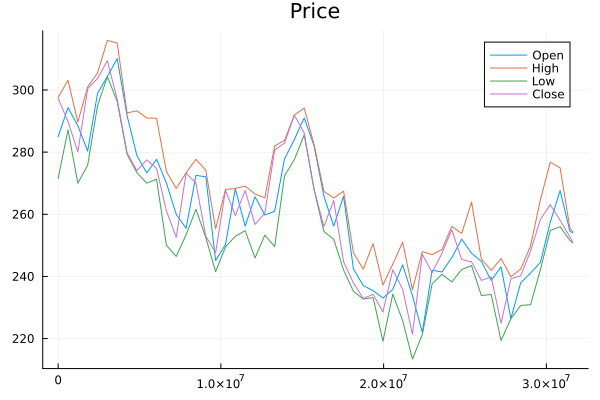

In [204]:
labels = ["Open", "High", "Low", "Close", "Volume", "Time"]

plot()
for index in 1:1:4
    plot!(stocks[:, 6, 1], stocks[:, index, 1], label=labels[index])
end
title!("Price")

# Split Data

In [205]:
# Reservoir parameters:
nodes = 500
radius = 10.
density = .2
leak = 0.2
ndrop = 30
lambda = 10^(-1)
noise_factor = .1


size(stocks)

(54, 6, 1, 2)

In [206]:
function normalize(X)
    time, features, segments, stocks = size(X)
    values = zeros(Float64, (features, segments, stocks, 2))
    for stock in 1:1:stocks
        for segment in 1:1:segments
            for feature in 1:1:features
                values[feature, segment, stock, 1], values[feature, segment, stock, 2] = [mean(X[:, feature, segment, stock]), std(X[:, feature, segment, stock])]
                X[:, feature, segment, stock] = (X[:, feature, segment, stock] .- mean(X[:, feature, segment, stock])) ./std(X[:, feature, segment, stock]) 
            end
        end
    end
    return X, values
end

X = stocks[:, :, :, :]

X[:, [1,2,3,4,5], :, :], values = normalize(X[:, [1,2,3,4,5], :, :])
print(size(X), " ", size(values))

(54, 6, 1, 2) (5, 1, 2, 2)

In [207]:
function split(X, ratio, ndrop)
    nsplits = size(ratio)[1]
    
    timelength, nfeatures, segments, nstocks = size(X)
    
    window_size = floor.(Int64, timelength.*ratio)
    npoint = sum(window_size)
    
    indices = zeros(Int64, nsplits+1)
    indices[1] = ndrop+1
    indices[2:end] = cumsum(window_size)
    
    print(indices, "\n")
        
    X = X[end-npoint:end, :, :, :]
    
    splits = [X[indices[split]-ndrop:indices[split+1], :, :, :] for split in 1:1:nsplits]
    
    """
    X = X[end-npoint:end, :, :]
    
    window_length = min(floor(Int64, size(X)[1]/n), ntrain+nval+ntest)
        
    X = reshape(X[(1+size(X)[1]-window_length*n):end, :, :], (window_length, size(X)[2], n, size(X)[3]))
    
    X_train = X[1:ntrain, :, :, :]
    X_val = X[1+ntrain:ntrain+nval, :, :, :]
    X_test = X[1+ntrain+nval:ntrain+nval+ntest, :, :, :]
    
    return X_train, X_val, X_test
    """
    #print(typeof(splits))
    return splits
end

split (generic function with 1 method)

In [208]:
split_ratio = [0.8, 0.1, 0.1]  # ratios [training, validation, test]

X_train, X_val, X_test = split(X, split_ratio, ndrop)

print(size(X_train), " ", size(X_val), " ", size(X_test), "\n")

[31, 43, 48, 53]
(43, 6, 1, 2) (36, 6, 1, 2) (36, 6, 1, 2)


In [209]:
include("./ESN/Reservoir.jl")
using .ESN

In [210]:
x_train = X_train[1:end-1, :, :, :]
y_train = X_train[ndrop+2:end, [1,2], 1, :]

x_train = reshape(x_train, (size(x_train)[2], size(x_train)[3], size(x_train)[1], size(x_train)[4]))
y_train = reshape(y_train, (size(y_train)[2], size(y_train)[1], size(y_train)[3]))

print(size(y_train), " ", size(x_train), "\n")

(2, 12, 2) (6, 1, 42, 2)


In [211]:
reservoir = ESN.generate_reservoir(x_train[:,:,:,1], y_train[:,:,1],
                                nodes=nodes,
                                radius=radius,
                                reservoir_density = density,
                                leak = leak,
                                ndrop = ndrop,
                                lambda = lambda,
                                noise_factor = noise_factor)

Main.ESN.Reservoir(500, 10.0, 0.2, 30, 0.1, [-1.804689325879428 -0.4205680945609603 … -1.009100023757125 1.18138270719594; 0.4597231911781905 -0.24863350532718906 … 0.28832914545478805 1.9088804018986079; … ; 0.6580111085077744 0.4990139393788592 … -1.3821701563391269 -1.5148595132854987; -0.489507057715513 0.6306405464962043 … -0.12062232094184036 -0.8270703568560632], [0.0 -0.2880713323828832 … 0.0 0.0; 0.0 0.5209310224914022 … 1.1198551379428425 -0.2230555341434637; … ; 0.0 0.0 … 1.2442653827079864 1.611443313194067; 0.0 0.0 … 1.070936471589561 0.0], [0.015537298494813001 0.005366120898564475 … 0.026894852052237184 0.033259700186825114; 0.006322823132116184 0.006291496524283957 … 0.02203666992789266 0.025813853644621076])

In [212]:
prediction = ESN.predict(x_train[:,:,:,1], reservoir)
print(size(prediction))

(2, 12)

In [213]:
function inv_normalize(X, values)
    features, time = size(X)
    for feature in 1:1:features
        X[feature, :] = values[feature, 2].*X[feature, :] .+ values[feature, 1] 
    end
    return X
end

prediction = inv_normalize(prediction, values[[1,4], 1, 1, :, 1])
y_train = inv_normalize(y_train[:,:,1], values[[1,4],1,1,:,1])

2×12 Matrix{Float64}:
 237.05   233.05   243.76   221.99   …  242.914  239.877  240.584  245.682
 234.877  235.293  233.201  241.558     227.028  238.412  247.632  255.517

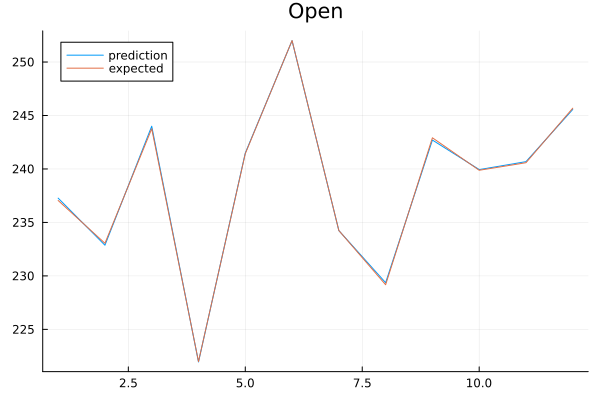

In [214]:
function representation(prediction, expected, title)
    plot(prediction, label="prediction")
    plot!(expected, label="expected")
    title!(title)
end

representation(prediction[1, :], y_train[1,:,1], "Open")

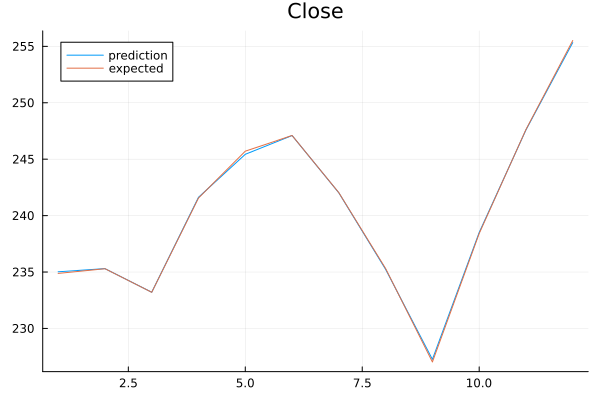

In [215]:
representation(prediction[2, :], y_train[2,:,1], "Close")

# Validation

In [216]:
x_val = X_val[1:end-1, :, :, :]
y_val = X_val[ndrop+2:end, [1,4], 1, :]

x_val = reshape(x_val, (size(x_val)[2], size(x_val)[3], size(x_val)[1], size(x_val)[4]))
y_val = reshape(y_val, (size(y_val)[2], size(y_val)[1], size(y_val)[3]))

prediction = ESN.predict(x_val[:,:,:,1], reservoir)

prediction = inv_normalize(prediction, values[[1,4], 1, 1, :, 1])
y_val = inv_normalize(y_val[:,:,1], values[[1,4],1,1,:,1])

2×5 Matrix{Float64}:
 244.86   243.08   237.97  240.278  239.697
 238.217  225.779  238.73  224.93   240.22

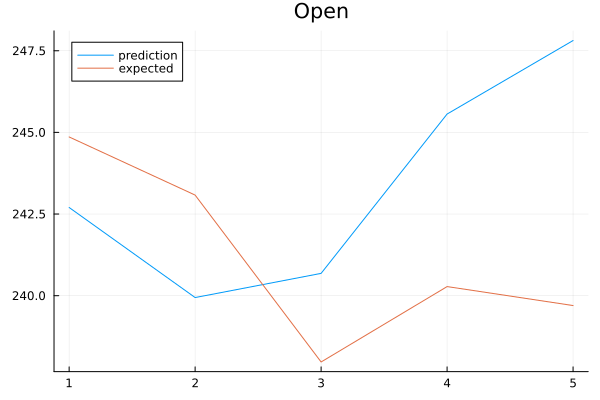

In [217]:
representation(prediction[1, :], y_val[1, :, 1], "Open")

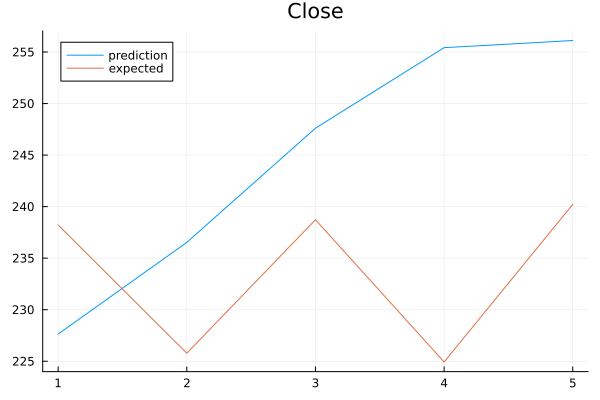

In [200]:
representation(prediction[2, :], y_val[2,:,1], "Close")

# test

In [163]:
x_test = X_test[1:end-1, :, :, :]
y_test = X_test[ndrop+2:end, [1,4], 1, :]

x_test = reshape(x_test, (size(x_test)[2], size(x_test)[3], size(x_test)[1], size(x_test)[4]))
y_test = reshape(y_test, (size(y_test)[2], size(y_test)[1], size(y_test)[3]))

prediction = ESN.predict(x_test[:,:,:,1], reservoir)

prediction = inv_normalize(prediction, values[[1,4], 1, 1, :, 1])
y_val = inv_normalize(y_val[:,:,1], values[[1,4],1,1,:,1])

2×5 Matrix{Float64}:
 5436.65  5399.03  5291.0   5339.75  5327.46
 5373.24  5106.29  5384.19  5088.0   5416.17

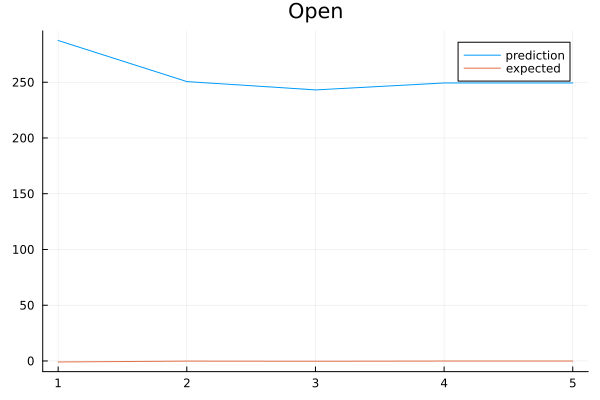

In [164]:
representation(prediction[1, :], y_test[1, :, 1], "Open")

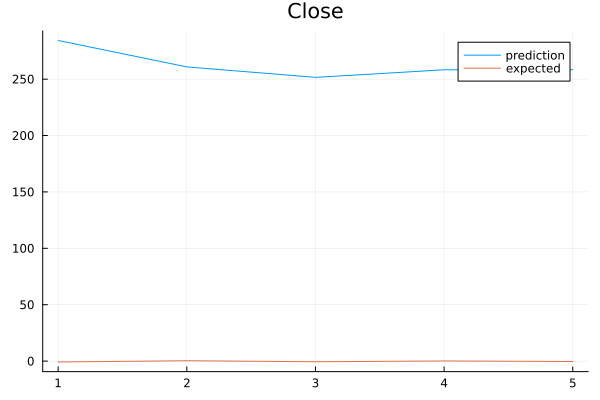

In [165]:
representation(prediction[2, :], y_test[2,:,1], "Close")